## Nature Language Process(NLP)

统计语言模型的核心思想就是判断一个文字序列是否能构成人类能够理解并且有意义的句子。

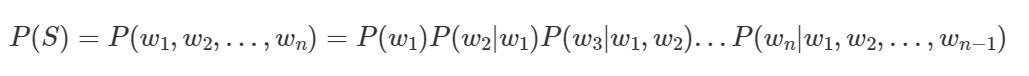

而预测序列的下一个单词即第N个单词，也就变成了他前面N-1个词语的条件概率。

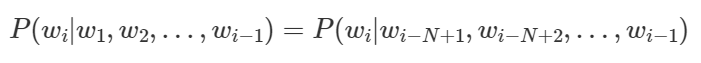

这种假设被称为马尔科夫假设，对应的语言模型也被称为N-Gram，常见的2-Gram、3-Gram，任意词语的出现只和他前面的1个、2个单词有关。

而在此基础上衍生的模型为了捕获之前更长的序列，产生了RNN、LSTM、Transformer等模型。


### Transformer模型

Transformer模型主要分为三类：
- Encoder-only模型（例如Bert）: 自编码模型
- Decoder-only模型（例如GPT）:  自回归模型
- Encoder-Decoder模型（例如BART、T5）: seq2seq模型

#### Transformer的架构

Transformer的标志是使用了注意力层(Attention Layers)的结构，注意力层的作用是让模型在处理文本时，将注意力只放在某些词语上。

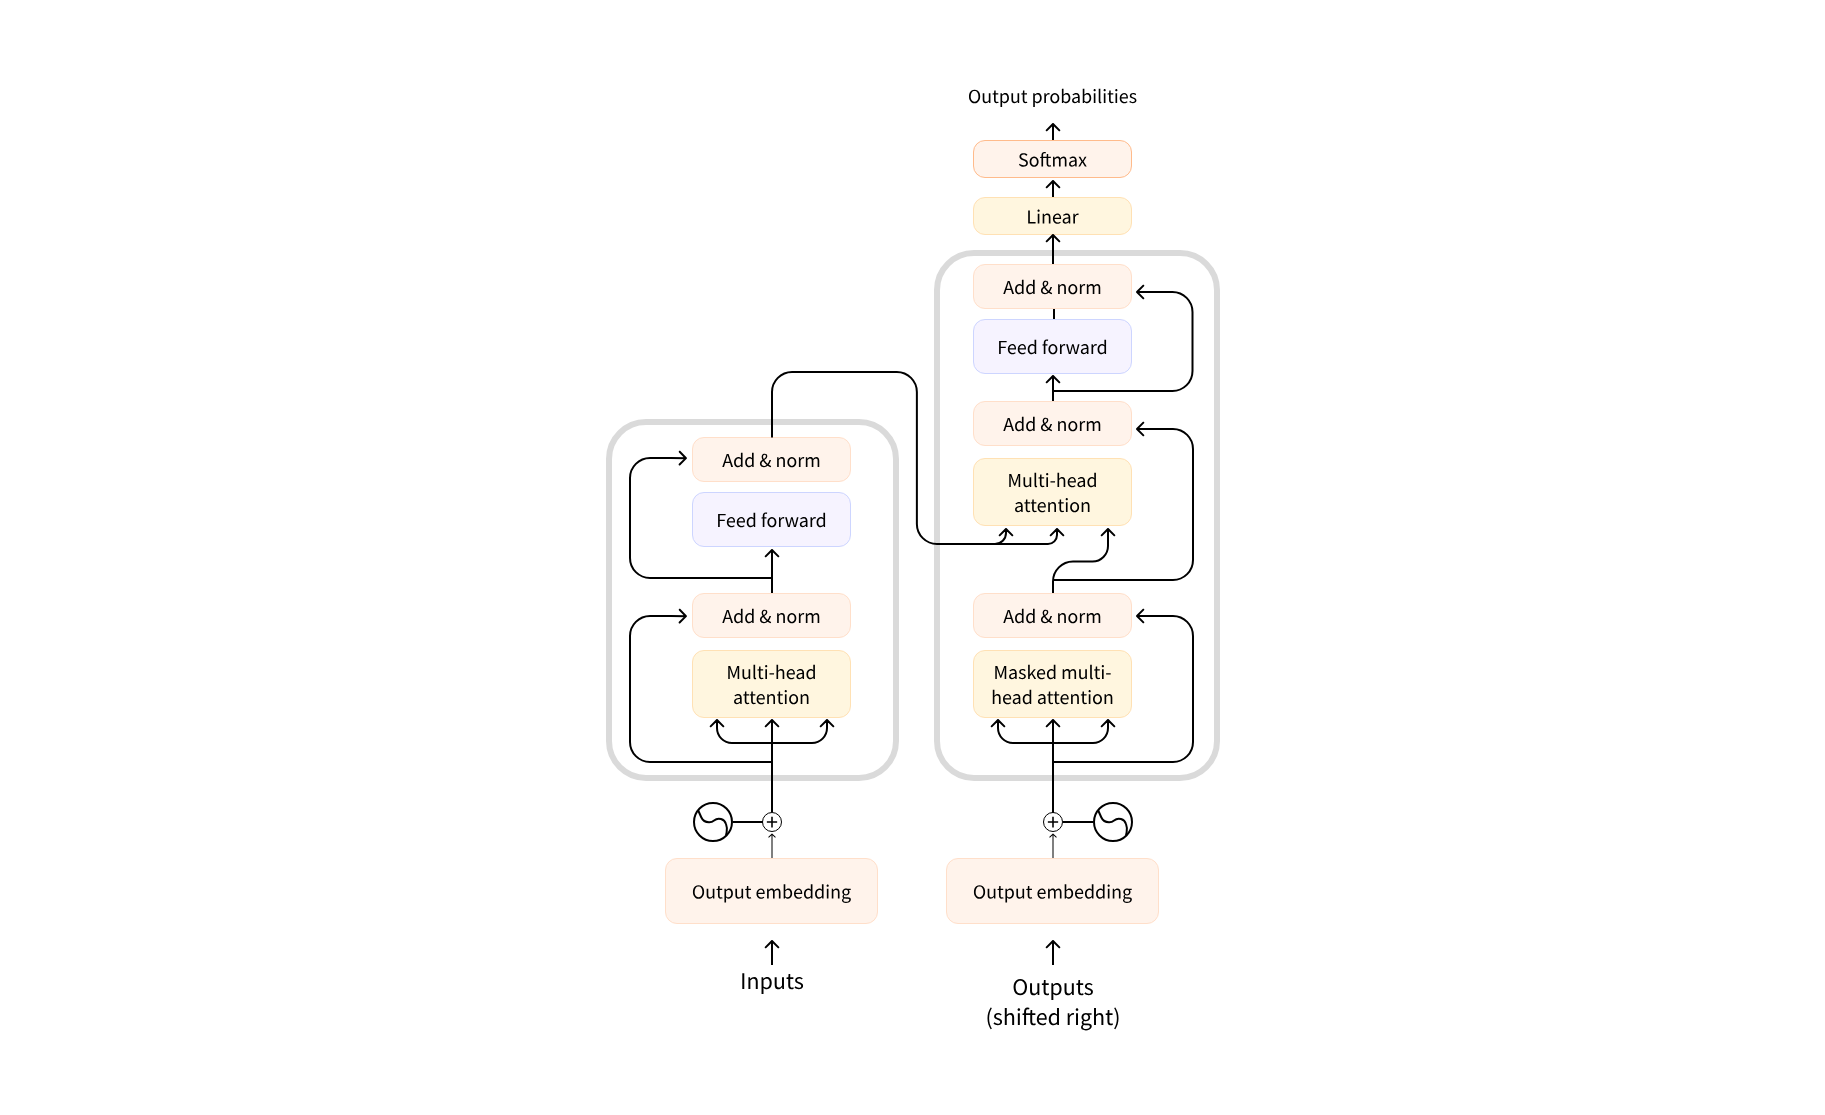

Transformer模型家族大致可以分为如下几类

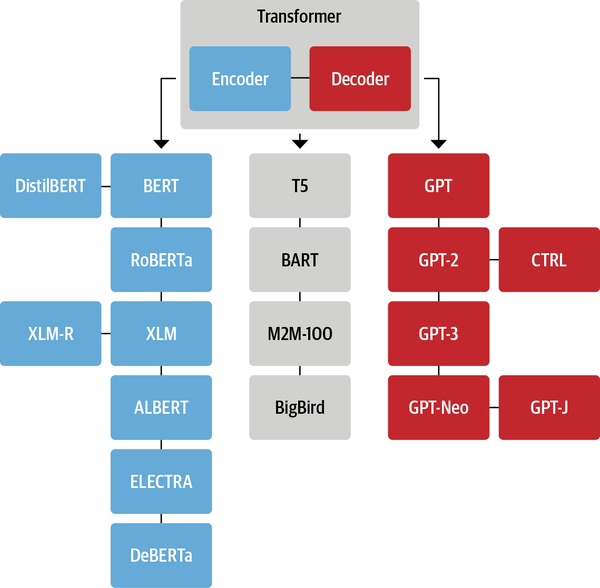

##### 注意力机制(Scaled Dot-product Attention)

Attention机制作用于整个文本，相比RNN逐步获得全局信息，而CNN只能获得局部信息，一步到位获得了全局信息。

核心机制Scaled Dot-product Attention

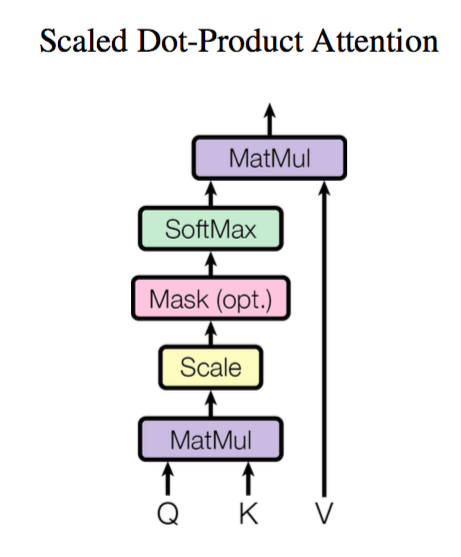

Scaled Dot-product Attention 主要包含两个步骤：
1. 计算注意力的权重：使用某种相似度函数度量每一个query向量和所有key向量之间的关联程度，对于长度为m的query序列和一个长度为n的Key序列，会生成一个mxn的注意力分组矩阵。由于点积灰产生一个大的数字，这个时候需要乘以一个缩放银子来标准化方差，然后使用softmax标准化。最终得到的结果是query和key之间的关联程度矩阵$w_{ij}$。
2. 更新token embeddings：将权重矩阵$w_{ij}$ 和对应的value向量相乘得到更新后的语义。

计算公式为: $Attention(Q, K, V) = softmax(\frac {QK^T} {\sqrt {d_k}}) V$

其中  $Q ∈ R^{m \times d_k}, K ∈ R^{n \times d_k}, V ∈ R^{n \times d_v} $ 最终得到$m \times d_v$的矩阵。

```python

import torch
import torch.nn.functional as F
from math import sqrt

def scaled_dot_product_attention(query, key, value, query_mask=None, key_mask=None, mask=None):
    dim_k = query.size(-1)
    scores = torch.bmm(query, key.transpose(1, 2)) / sqrt(dim_k)
    if query_mask is not None and key_mask is not None:
        mask = torch.bmm(query_mask.unsqueeze(-1), key_mask.unsqueeze(1))
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -float("inf"))
    weights = F.softmax(scores, dim=-1)
    return torch.bmm(weights, value)
```


##### 多头机制 (Multi-Head Attention)

Multi-Head Attention 线性映射将Q、K、V序列映射到特征空间，每一组投影后的向量成为一个头。然后在魅族映射后的序列上在进行Scaled Dot-product Attention。

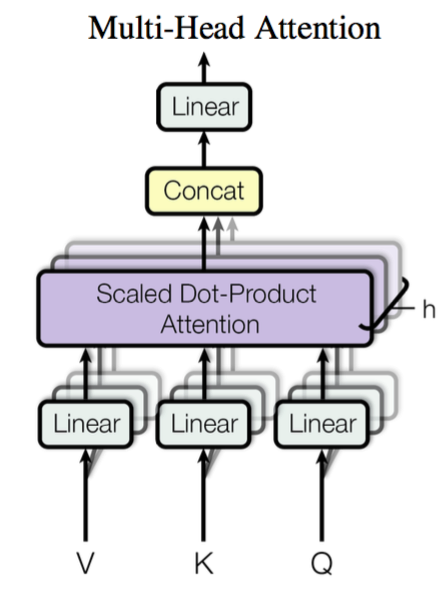

$$
\begin{align}
head_i &= Attention(QW_i^Q, KW_i^K, VW_i^V) \\
MultiHead(Q, K, V) &= Concat(head_1, ..., head_h)

\end{align}
$$

其中h为注意力头的数量， 一般都将 head_dim设置为embed_dim的因数，而embed_dim 也基本上是hidden_size，head_dim = embed_dim / num_heads
```python

from torch import nn

class AttentionHead(nn.Module):
    def __init__(self, embed_dim, head_dim):
        super().__init__()
        self.q = nn.Linear(embed_dim, head_dim)
        self.k = nn.Linear(embed_dim, head_dim)
        self.v = nn.Linear(embed_dim, head_dim)

    def forward(self, query, key, value, query_mask=None, key_mask=None, mask=None):
        attn_outputs = scaled_dot_product_attention(
            self.q(query), self.k(key), self.v(value), query_mask, key_mask, mask)
        return attn_outputs

class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        embed_dim = config.hidden_size
        num_heads = config.num_attention_heads
        head_dim = embed_dim // num_heads
        self.heads = nn.ModuleList(
            [AttentionHead(embed_dim, head_dim) for _ in range(num_heads)]
        )
        self.output_linear = nn.Linear(embed_dim, embed_dim)

    def forward(self, query, key, value, query_mask=None, key_mask=None, mask=None):
        x = torch.cat([
            h(query, key, value, query_mask, key_mask, mask) for h in self.heads
        ], dim=-1)
        x = self.output_linear(x)
        return x

```


##### Decoder和Encoder的差异

Decoder 增加了mask机制，确保每个时间生成的词语仅基于过的输入和当前的预测


##### Positional Embeddings

由于注意力机制无法捕捉词语之间的位置信息，因此Transformer模型还使用了Postional Embeddings添加了词语的位置信息，核心思想：使用位置相关的值来增强词向量。

存在替代方案：
- 绝对位置表示： 使用调制的正弦和余弦信号组成的静态模式编码位置，比如rotary emebeddings
- 相对位置表示

### 相关论文

[Attention is All Your Need](https://arxiv.org/abs/1706.03762)


